# Hello MNIST Binary Classifier ("5" or "not 5")

In [1]:
# Prerequisites
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
print("Python Version: ", sys.version)
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
np.set_printoptions(precision=3, suppress=True)

Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Numpy Version:  2.2.2
Pandas Version:  2.2.3


### Load Data

In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)  # Load as Numpy array (not pandas dataframe)
print("Type: ", type(mnist))

Type:  <class 'sklearn.utils._bunch.Bunch'>


### Explore Data

In [9]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [42]:
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [10]:
print("Type of data: ", type(mnist.data))
print("Type of target: ", type(mnist.target))


Type of data:  <class 'numpy.ndarray'>
Type of target:  <class 'numpy.ndarray'>


In [12]:
X, y = mnist.data, mnist.target
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Shape of X:  (70000, 784)
Shape of y:  (70000,)


#### Plot a digit

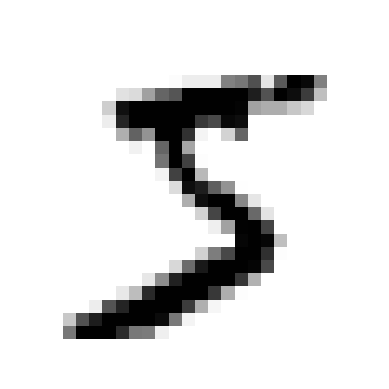

Label:  5


In [14]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'binary')
    plt.axis("off")

plot_digit(X[0])
plt.show()
print("Label: ", y[0])

Create Train and Test Set

In [15]:
# Create Train and test sets
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

### Train a Binary Classifier ("5" or "Not 5")

In [19]:
# Create binary target vectors, True for 5, False if not 5
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')
print("y_train_5: ", y_train_5[:20])

y_train_5:  [ True False False False False False False False False False False  True
 False False False False False False False False]


Train Stochastic Gradient Descend Classifier (SGDClassifier)

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Check predictions on a few digits

In [28]:
for i in range(8):
    print(f"digit = {y_train[i]}, predict = {sgd_classifier.predict([X_train[i]])}, actual = {y_train_5[i]}")

digit = 5, predict = [ True], actual = True
digit = 0, predict = [False], actual = False
digit = 4, predict = [False], actual = False
digit = 1, predict = [False], actual = False
digit = 9, predict = [False], actual = False
digit = 2, predict = [False], actual = False
digit = 1, predict = [False], actual = False
digit = 3, predict = [False], actual = False


### Evaluate Performace with Cross-Validation

In [29]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95, 0.96, 0.96])

Compare with DummyClassifier that will always return the most frequent class, i.e. "Not 5"

In [32]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train_5)
print(any(dummy_classifier.predict(X_train)==True))

False


In [33]:
# Check dummy cross validation score
cross_val_score(dummy_classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91, 0.91, 0.91])

### Confusion Matrix

In [34]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)
print("Type: ", type(y_train_pred))
print("Shape: ", y_train_pred.shape)

Type:  <class 'numpy.ndarray'>
Shape:  (60000,)


In [35]:
from sklearn.metrics import confusion_matrix

# Get Confusion Matrix
conf_mat = confusion_matrix(y_train_5, y_train_pred)
conf_mat

array([[53892,   687],
       [ 1891,  3530]])

### Precision, Recall, F1-Score

In [36]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
print("Precision: ", precision)
recall = recall_score(y_train_5, y_train_pred)
print("Recall: ", recall)

Precision:  0.8370879772350012
Recall:  0.6511713705958311


In [38]:
# Double check from Confusion Matrix
# Precision = TP / (TP + FP) 
print("Precision" , 3530 / (3530 + 687))
# Recall = TP / (TP + FN) 
print("Precision" , 3530 / (3530 +1891))

Precision 0.8370879772350012
Precision 0.6511713705958311


In [40]:
from sklearn.metrics import f1_score

# F1 Score
f1 = f1_score(y_train_5, y_train_pred)
print("f1: ", f1)


f1:  0.7325171197343847


In [41]:
# Double check with harmonic mean of precision and recall 
f1 = 2 / (1/precision + 1/recall)
print("f1: ", f1)

f1:  0.7325171197343847


### Precision vs. Recall

Access the decision scores used by the classifier

In [44]:
decision_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method="decision_function")

In [54]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, decision_scores)

In [55]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

Plot the Precision vs. Recall

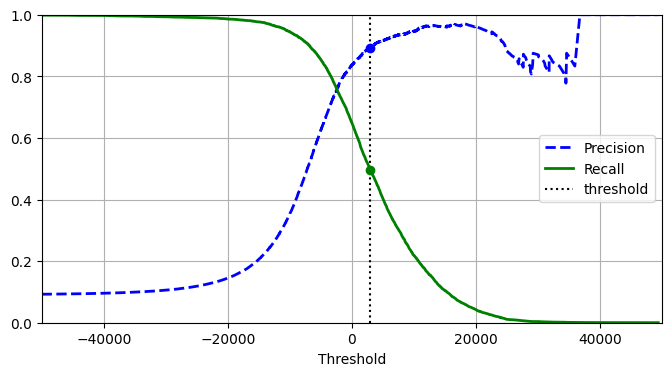

In [47]:
threshold = 3000

plt.figure(figsize=(8, 4))  
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

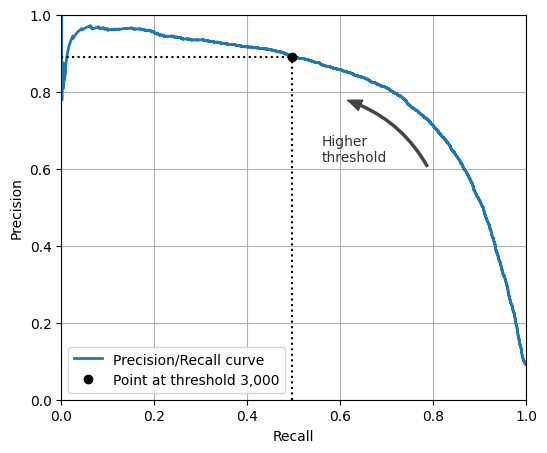

In [48]:
import matplotlib.patches as patches  # for curved arrow

plt.figure(figsize=(6, 5)) 

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

### ROC Curve

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, decision_scores)

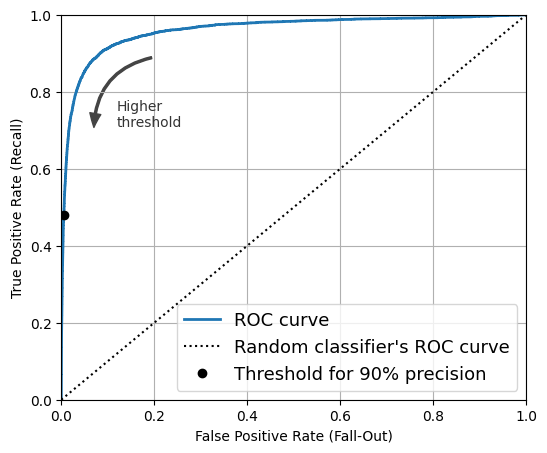

In [59]:

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()